In [32]:
import os
from tqdm import tqdm
import json

import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from rdkit import Chem
from rdkit.Chem import Draw
import json
import networkx as nx

import matplotlib.pyplot as plt
%matplotlib inline

from src.utils import create_edge_index, PLIDataset, set_all_seeds, GCN, save_model
from src.edgeshaper import Edgeshaper

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
set_all_seeds(42)

In [3]:
DATA_PATH = 'data/pdbbind/dataset/'

## EDA

read mol2 files

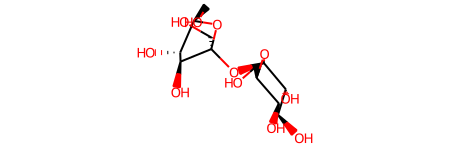

In [28]:
target_mol_name = "1a0t"
mol = Chem.MolFromMol2File(DATA_PATH + target_mol_name + "/" + target_mol_name + "_ligand.mol2")
test_mol = Draw.PrepareMolForDrawing(mol)
test_mol


In [29]:
num_bonds = len(test_mol.GetBonds())
num_atoms = len(test_mol.GetAtoms())

print("Number of bonds: ", num_bonds)
print("Number of atoms: ", num_atoms)

rdkit_bonds = {}

for i in range(num_bonds):
    init_atom = test_mol.GetBondWithIdx(i).GetBeginAtomIdx()
    end_atom = test_mol.GetBondWithIdx(i).GetEndAtomIdx()
    bond_type = test_mol.GetBondWithIdx(i).GetBondType()
    print("Bond: ", i, " " , init_atom, "-" , end_atom, " ", bond_type)
    rdkit_bonds[(init_atom, end_atom)] = i
    #CNC(=O)CN1CN(c2ccccc2)C2(CCN(Cc3cc4c(cc3Cl)OCO4)CC2)C1=O
# rdkit_bonds

Number of bonds:  24
Number of atoms:  23
Bond:  0   0 - 1   SINGLE
Bond:  1   0 - 6   SINGLE
Bond:  2   0 - 10   SINGLE
Bond:  3   1 - 2   SINGLE
Bond:  4   1 - 7   SINGLE
Bond:  5   2 - 3   SINGLE
Bond:  6   2 - 8   SINGLE
Bond:  7   3 - 4   SINGLE
Bond:  8   3 - 9   SINGLE
Bond:  9   4 - 5   SINGLE
Bond:  10   4 - 10   SINGLE
Bond:  11   5 - 11   SINGLE
Bond:  12   6 - 13   SINGLE
Bond:  13   13 - 12   SINGLE
Bond:  14   12 - 18   SINGLE
Bond:  15   13 - 14   SINGLE
Bond:  16   13 - 19   SINGLE
Bond:  17   14 - 15   SINGLE
Bond:  18   14 - 20   SINGLE
Bond:  19   15 - 16   SINGLE
Bond:  20   15 - 21   SINGLE
Bond:  21   16 - 17   SINGLE
Bond:  22   16 - 19   SINGLE
Bond:  23   17 - 22   SINGLE


read json interaction graph

In [30]:
with open(DATA_PATH + target_mol_name + "/" + target_mol_name + "_interaction_graph.json", 'r') as f:
  data = json.load(f)

print("Number of atoms: ", len(data['nodes']))
print("Number of bonds: ", len(data['edges']))

Number of atoms:  45
Number of bonds:  1024


In [31]:
print(data['nodes'])

[{'id': 0, 'attype': 'N', 'pl': 'L'}, {'id': 1, 'attype': 'N', 'pl': 'L'}, {'id': 2, 'attype': 'N', 'pl': 'L'}, {'id': 3, 'attype': 'N', 'pl': 'L'}, {'id': 4, 'attype': 'N', 'pl': 'L'}, {'id': 5, 'attype': 'N', 'pl': 'L'}, {'id': 6, 'attype': 'N', 'pl': 'L'}, {'id': 7, 'attype': 'N', 'pl': 'L'}, {'id': 8, 'attype': 'N', 'pl': 'L'}, {'id': 9, 'attype': 'N', 'pl': 'L'}, {'id': 10, 'attype': 'N', 'pl': 'L'}, {'id': 11, 'attype': 'O', 'pl': 'L'}, {'id': 12, 'attype': 'O', 'pl': 'L'}, {'id': 13, 'attype': 'O', 'pl': 'L'}, {'id': 14, 'attype': 'O', 'pl': 'L'}, {'id': 15, 'attype': 'O', 'pl': 'L'}, {'id': 16, 'attype': 'O', 'pl': 'L'}, {'id': 17, 'attype': 'O', 'pl': 'L'}, {'id': 18, 'attype': 'O', 'pl': 'L'}, {'id': 19, 'attype': 'CA', 'pl': 'L'}, {'id': 20, 'attype': 'CA', 'pl': 'L'}, {'id': 21, 'attype': 'CA', 'pl': 'L'}, {'id': 22, 'attype': 'CA', 'pl': 'L'}, {'id': 23, 'attype': 'CA', 'pl': 'L'}, {'id': 24, 'attype': 'CA', 'pl': 'L'}, {'id': 25, 'attype': 'CA', 'pl': 'L'}, {'id': 26, 'at

Visualize interaction graph - red atoms from Protein and lightblue atoms from Ligand

In [32]:
G = nx.Graph()

for edge in data['edges']:
    if edge["id1"] != None and edge["id2"] != None:
        G.add_edge(edge["id1"], edge["id2"], weight=edge["length"])

for node in data['nodes']:
    nx.set_node_attributes(G, {node["id"]: node["attype"]}, "atom_type")
    nx.set_node_attributes(G, {node["id"]: node["pl"]}, "from")

print("Number of nodes: ", G.number_of_nodes())
print("Number of edges: ", G.number_of_edges())

colors = ["red" if G.nodes[node]["from"] == "P" else "lightblue" for node in G.nodes]

# nx.draw_networkx_edge_labels(G, pos=nx.spring_layout(G), edge_labels=nx.get_edge_attributes(G, 'weight'))
plt.figure(figsize=(10,10))
pos = nx.spring_layout(G)
nx.draw(G, pos=pos, with_labels=True, font_weight='bold', labels=nx.get_node_attributes(G, 'atom_type'), node_color=colors)
# nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=nx.get_edge_attributes(G, 'weight'))

Number of nodes:  45
Number of edges:  247


#### Gather affinity values

## Load dataset

In [4]:
directory = os.fsencode(DATA_PATH)

data_versions = [2020, 2019, 2016]
interaction_affinities = {}

for file in tqdm(os.listdir(directory)):
    interaction_name = os.fsdecode(file)
    if os.path.isdir(DATA_PATH + interaction_name):
        for version in data_versions:
            INDEX_PATH = "data/pdbbind/PDBbind_v" + str(version) + "_plain_text_index/index/INDEX_general_PL_data." + str(version)
            with open(INDEX_PATH, 'r') as f:
                interaction_info = f.readlines()[5:]
                for line in interaction_info:
                    row = line.strip().split(" ")
                    if row[0] == interaction_name:
                        row = list(filter(lambda a: a != "", row)) #remove empty strings
                        
                        affinity = float(row[3])
                        
                        interaction_affinities[interaction_name] = affinity
                        break
            

  1%|▏         | 180/14219 [00:04<05:21, 43.62it/s]


KeyboardInterrupt: 

In [ ]:
with open(DATA_PATH + '/interaction_affinities.json', 'w+') as fp:
    json.dump(interaction_affinities, fp, sort_keys=True, indent=4)

In [5]:
with open(DATA_PATH + '/interaction_affinities.json', 'r') as fp:
    interaction_affinities = json.load(fp)

In [6]:
def generate_pli_dataset_dict(data_path):

    directory = os.fsencode(data_path)

    dataset_dict = {}
    dirs = os.listdir(directory)
    for file in tqdm(dirs):
        interaction_name = os.fsdecode(file)
        if os.path.isdir(data_path + interaction_name):
            dataset_dict[interaction_name] = {}
            with open(data_path + interaction_name + "/" + interaction_name + "_interaction_graph.json", 'r') as f:
                data = json.load(f)
                G = nx.Graph()

                for edge in data['edges']:
                    if edge["id1"] != None and edge["id2"] != None:
                        G.add_edge(edge["id1"], edge["id2"], weight=edge["length"])

                for node in data['nodes']:
                    nx.set_node_attributes(G, {node["id"]: node["attype"]}, "atom_type")
                    nx.set_node_attributes(G, {node["id"]: node["pl"]}, "from")

                # print(nx.to_scipy_sparse_matrix(G).tocoo())
                
            dataset_dict[interaction_name]["networkx_graph"] = G
            edge_index, edge_weight = create_edge_index(G, weighted=True)

            dataset_dict[interaction_name]["edge_index"] = edge_index
            dataset_dict[interaction_name]["edge_weight"] = edge_weight
            # dataset_dict[interaction_name]["edge_weight"] = 

            num_nodes = G.number_of_nodes()
            dataset_dict[interaction_name]["x"] = torch.full((num_nodes, 1), 1.0, dtype=torch.float)#dummy feature

            ## gather label
            dataset_dict[interaction_name]["y"] = torch.FloatTensor([interaction_affinities[interaction_name]])
    
    return dataset_dict
        
pli_dataset_dict = generate_pli_dataset_dict(DATA_PATH)     

100%|██████████| 14219/14219 [00:24<00:00, 580.67it/s]


### create torch dataset

In [7]:
data_list = []
for interaction_name in tqdm(pli_dataset_dict):
    data_list.append(Data(x = pli_dataset_dict[interaction_name]["x"], edge_index = pli_dataset_dict[interaction_name]["edge_index"], edge_weight = pli_dataset_dict[interaction_name]["edge_weight"], y = pli_dataset_dict[interaction_name]["y"], networkx_graph = pli_dataset_dict[interaction_name]["networkx_graph"], interaction_name = interaction_name))

100%|██████████| 14215/14215 [00:00<00:00, 30894.89it/s]


In [8]:
dataset = PLIDataset(".", data_list = data_list)

In [9]:
train_interactions = []
val_interactions = []
core_set_interactions = []
hold_out_interactions = []

with open("data/pdbbind/pdb_ids/training_set.csv", 'r') as f:
    train_interactions = f.readlines()

train_interactions = [interaction.strip() for interaction in train_interactions]

with open("data/pdbbind/pdb_ids/validation_set.csv", 'r') as f:
    val_interactions = f.readlines()

val_interactions = [interaction.strip() for interaction in val_interactions]

with open("data/pdbbind/pdb_ids/core_set.csv", 'r') as f:
    core_set_interactions = f.readlines()

core_set_interactions = [interaction.strip() for interaction in core_set_interactions]

with open("data/pdbbind/pdb_ids/hold_out_set.csv", 'r') as f:
    hold_out_interactions = f.readlines()

hold_out_interactions = [interaction.strip() for interaction in hold_out_interactions]

In [10]:
train_data = [dataset[i] for i in range(len(dataset)) if dataset[i].interaction_name in train_interactions]
val_data = [dataset[i] for i in range(len(dataset)) if dataset[i].interaction_name in val_interactions]
core_set_data = [dataset[i] for i in range(len(dataset)) if dataset[i].interaction_name in core_set_interactions]
hold_out_data = [dataset[i] for i in range(len(dataset)) if dataset[i].interaction_name in hold_out_interactions]

In [11]:
BATCH_SIZE = 32

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE)
core_set_loader = DataLoader(core_set_data, batch_size=BATCH_SIZE)
hold_out_loader = DataLoader(hold_out_data, batch_size=BATCH_SIZE)


In [12]:
# num_classes  =  1 even for regression
model = GCN(node_features_dim = dataset[0].x.shape[1], num_classes = 1, hidden_channels=256).to(device)

In [13]:
model.load_state_dict(torch.load("models/model_2022_11_08-15_47_33.ckpt"))
model.to(device)
model

GCN(
  (conv1): GCNConv(1, 256)
  (conv2): GCNConv(256, 256)
  (conv3): GCNConv(256, 256)
  (conv4): GCNConv(256, 256)
  (lin): Linear(256, 1, bias=True)
)

### Train the network

In [14]:
#training the network
lr = lr=1e-3
EPOCHS = 100
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.MSELoss()

epochs = EPOCHS

In [15]:
def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch, edge_weight = data.edge_weight)  # Perform a single forward pass.
        loss = torch.sqrt(criterion(torch.squeeze(out), data.y))  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

def test(loader):
    model.eval()

    sum_loss = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        data = data.to(device)
        
        out = model(data.x, data.edge_index, data.batch, edge_weight = data.edge_weight)  
        loss = torch.sqrt(criterion(torch.squeeze(out), data.y)) 
        sum_loss += loss.item()
    return sum_loss / len(loader.dataset)  # Derive ratio of correct predictions.

In [17]:
for epoch in range(epochs):
    train()
    train_rmse = test(train_loader)
    val_rmse = test(val_loader)
    print(f'Epoch: {epoch:03d}, Train RMSE: {train_rmse:.4f}, Val RMSE: {val_rmse:.4f}')

core_set_rmse = test(core_set_loader)    
print(f'Core set 2016 RMSE: {core_set_rmse:.4f}')

hold_out_set_rmse = test(hold_out_loader)    
print(f'Hold out set 2019 RMSE: {hold_out_set_rmse:.4f}')

Epoch: 000, Train RMSE: 0.0662, Val RMSE: 0.0724
Epoch: 001, Train RMSE: 0.0633, Val RMSE: 0.0697
Epoch: 002, Train RMSE: 0.0606, Val RMSE: 0.0672
Epoch: 003, Train RMSE: 0.0596, Val RMSE: 0.0664
Epoch: 004, Train RMSE: 0.0591, Val RMSE: 0.0660
Epoch: 005, Train RMSE: 0.0589, Val RMSE: 0.0658
Epoch: 006, Train RMSE: 0.0582, Val RMSE: 0.0653
Epoch: 007, Train RMSE: 0.0585, Val RMSE: 0.0654
Epoch: 008, Train RMSE: 0.0584, Val RMSE: 0.0654
Epoch: 009, Train RMSE: 0.0582, Val RMSE: 0.0652
Epoch: 010, Train RMSE: 0.0584, Val RMSE: 0.0654
Epoch: 011, Train RMSE: 0.0583, Val RMSE: 0.0653
Epoch: 012, Train RMSE: 0.0583, Val RMSE: 0.0653
Epoch: 013, Train RMSE: 0.0585, Val RMSE: 0.0655
Epoch: 014, Train RMSE: 0.0583, Val RMSE: 0.0653
Epoch: 015, Train RMSE: 0.0586, Val RMSE: 0.0656
Epoch: 016, Train RMSE: 0.0590, Val RMSE: 0.0659
Epoch: 017, Train RMSE: 0.0585, Val RMSE: 0.0655
Epoch: 018, Train RMSE: 0.0586, Val RMSE: 0.0656
Epoch: 019, Train RMSE: 0.0590, Val RMSE: 0.0659
Epoch: 020, Train RM

c:\Users\Mastro\anaconda3\envs\edgeshaper\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Hold out set 2019 RMSE: 0.0563


In [18]:
save_model(model, "models")

In [16]:
core_set_rmse = test(core_set_loader)    
print(f'Core set 2016 RMSE: {core_set_rmse:.4f}')


Core set 2016 RMSE: 0.0839


c:\Users\Mastro\anaconda3\envs\edgeshaper\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [17]:
hold_out_set_rmse = test(hold_out_loader)    
print(f'Hold out set 2019 RMSE: {hold_out_set_rmse:.4f}')

Hold out set 2019 RMSE: 0.0563


## Explainability

In [18]:
test_interaction = hold_out_data[1]
test_interaction

Data(x=[7, 1], edge_index=[2, 24], y=[1], edge_weight=[24], networkx_graph=Graph with 7 nodes and 12 edges, interaction_name='1b42')

In [19]:
batch = torch.zeros(test_interaction.x.shape[0], dtype=int, device=test_interaction.x.device)
                
out = model(test_interaction.x.to(device), test_interaction.edge_index.to(device), batch=batch.to(device), edge_weight=test_interaction.edge_weight.to(device))

In [20]:
out[None][None].item()

6.536458969116211

In [26]:
import torch.nn.functional as F

out_prob_real = F.softmax(out, dim = 1)[0][None].item()
out_prob_real = out.item()
out_prob_real

6.536458969116211

In [21]:
edgeshaper_explainer = Edgeshaper(model, test_interaction.x, test_interaction.edge_index, edge_weight = test_interaction.edge_weight, device = device)

phi_edges = edgeshaper_explainer.explain(M = 100, target_class = None, deviation = 1e-3, seed = 42)

No target class specified. Regression model assumed.


100%|██████████| 100/100 [00:26<00:00,  3.70it/s]


In [22]:
test_interaction.edge_index

tensor([[0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 6, 6, 6],
        [1, 0, 3, 4, 5, 6, 3, 4, 5, 6, 1, 2, 4, 6, 1, 2, 3, 5, 1, 2, 4, 1, 2, 3]])

In [23]:
sum(phi_edges)

0.9485115361213684

In [39]:
rdkit_bonds = dict(test_interaction.networkx_graph.edges())

In [42]:
test_interaction.networkx_graph.edges()

EdgeView([(6, 5), (5, 1), (5, 2), (5, 3), (5, 4), (0, 1), (0, 2), (0, 3), (0, 4), (1, 2), (1, 4), (2, 3)])

In [43]:
bonds = dict(test_interaction.networkx_graph.edges())
bonds = list(bonds.keys())
bonds

[(6, 5),
 (5, 1),
 (5, 2),
 (5, 3),
 (5, 4),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (1, 2),
 (1, 4),
 (2, 3)]

In [44]:
num_bonds = test_interaction.networkx_graph.number_of_edges()
rdkit_bonds_phi = [0]*num_bonds
rdkit_bonds = {}

bonds = dict(test_interaction.networkx_graph.edges())
bonds = list(bonds.keys())

for i in range(num_bonds):
    init_atom = bonds[i][0]
    end_atom = bonds[i][1]
    
    rdkit_bonds[(init_atom, end_atom)] = i

for i in range(len(phi_edges)):
    phi_value = phi_edges[i]
    init_atom = test_interaction.edge_index[0][i].item()
    end_atom = test_interaction.edge_index[1][i].item()
    
    if (init_atom, end_atom) in rdkit_bonds:
        bond_index = rdkit_bonds[(init_atom, end_atom)]
        rdkit_bonds_phi[bond_index] += phi_value
    if (end_atom, init_atom) in rdkit_bonds:
        bond_index = rdkit_bonds[(end_atom, init_atom)]
        rdkit_bonds_phi[bond_index] += phi_value

rdkit_bonds_phi

[0,
 -0.0035381317138671892,
 0.045276551246643065,
 0,
 0.2073694682121277,
 0.24628103256225586,
 0,
 0,
 0,
 0,
 0.002996211051940917,
 0.1233462929725647]

### Visualize explanations

In [24]:
G = test_interaction.networkx_graph
print("Number of nodes: ", G.number_of_nodes())
print("Number of edges: ", G.number_of_edges())

colors = ["red" if G.nodes[node]["from"] == "P" else "lightblue" for node in G.nodes]

# nx.draw_networkx_edge_labels(G, pos=nx.spring_layout(G), edge_labels=nx.get_edge_attributes(G, 'weight'))


Number of nodes:  7
Number of edges:  12


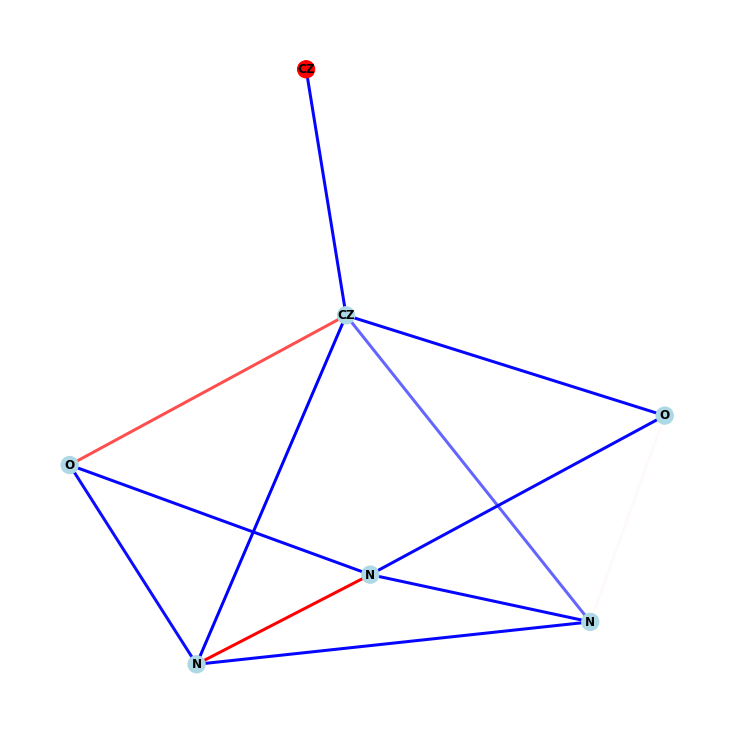

In [55]:
plt.figure(figsize=(10,10))
pos = nx.spring_layout(G)
nx.draw(G, pos=pos, with_labels=True, font_weight='bold', labels=nx.get_node_attributes(G, 'atom_type'), node_color=colors,edge_color=rdkit_bonds_phi, width=3, edge_cmap=plt.cm.bwr)